In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [242]:
import inspect
inspect.getsourcelines(preprocessing.scale) 

(['def scale(X, axis=0, with_mean=True, with_std=True, copy=True):\n',
  '    """Standardize a dataset along any axis\n',
  '\n',
  '    Center to the mean and component wise scale to unit variance.\n',
  '\n',
  '    Read more in the :ref:`User Guide <preprocessing_scaler>`.\n',
  '\n',
  '    Parameters\n',
  '    ----------\n',
  '    X : {array-like, sparse matrix}\n',
  '        The data to center and scale.\n',
  '\n',
  '    axis : int (0 by default)\n',
  '        axis used to compute the means and standard deviations along. If 0,\n',
  '        independently standardize each feature, otherwise (if 1) standardize\n',
  '        each sample.\n',
  '\n',
  '    with_mean : boolean, True by default\n',
  '        If True, center the data before scaling.\n',
  '\n',
  '    with_std : boolean, True by default\n',
  '        If True, scale the data to unit variance (or equivalently,\n',
  '        unit standard deviation).\n',
  '\n',
  '    copy : boolean, optional, default True\n',

In [3]:
test_size=0.2

df_train = pd.read_csv(r'train.csv')
df_train.index = df_train.PassengerId

y = df_train.Survived.values
df_train = df_train.drop(['Survived'], axis=1)

#remove columns
df_train = df_train.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)

#fill n/a
df_train['Age'] = df_train.Age.fillna(-1)
df_train['Embarked'] = df_train.Embarked.fillna('X')

#one hot encoding. OK to do it for all data, inlcuding df_predict
df_train['Sex'] = (df_train.Sex == 'male').astype(int)

df_dummy = pd.get_dummies(df_train.Embarked, prefix='Embarked')
df_train = df_train.drop(['Embarked'], axis=1)
df_train = pd.concat((df_train, df_dummy), axis=1)

#df_train
#df_predict

X = df_train.values
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=test_size, random_state=0)

#scale: X = (X - X.mean(axis=0))/np.sqrt(X.var(axis=0))
#X = preprocessing.scale(X)

#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(712, 10)
(712,)
(179, 10)
(179,)


In [6]:
df_train.Embarked_C.describe()

count    891.000000
mean       0.188552
std        0.391372
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Embarked_C, dtype: float64

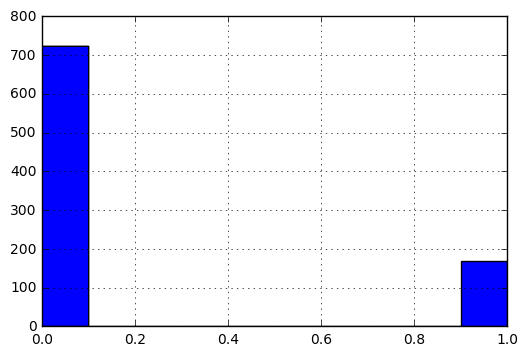

In [119]:
df_train.Embarked_C.hist()
plt.show()

In [7]:
np.random.seed(0) # set a seed so that the results are consistent

clfs = [sklearn.linear_model.LogisticRegressionCV(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1)]  

for clf in clfs:
    clf.fit(X_train, y_train);
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    predictions = clf.predict(X_dev)
    accuracy2 = accuracy_score(predictions, y_dev)
    print(type(clf), accuracy, accuracy2)
   

<class 'sklearn.linear_model.logistic.LogisticRegressionCV'> 0.803370786517 0.804469273743
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.981741573034 0.843575418994


In [8]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
        


In [9]:
np.random.seed(0) # set a seed so that the results are consistent
#for tanh
initializer = keras.initializers.lecun_normal()
regularizer = None
#regularizer = regularizers.l2(0.1)
model = Sequential()
model.add(Dense(20, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(10, kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', kernel_regularizer=regularizer))
#optimizer = optimizers.SGD(lr=0.05, momentum=0.9)
optimizer = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
np.random.seed(0) # set a seed so that the results are consistent
initial_epoch = 100000
epochs = 500000
verbose = 0
verbose2 = 10000
batch_size = int(X_train_k.shape[0])

results = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)
Y_predict_k = model.predict(X_train_k)
Y_predict_k = Y_predict_k > 0.5
print('Accuracy train', accuracy_score(Y_train_k, Y_predict_k))
Y_predict_k = model.predict(X_dev_k)
Y_predict_k = Y_predict_k > 0.5
print('Accuracy dev', accuracy_score(Y_dev_k, Y_predict_k))

100000 0.0935170277953 0.971910119057 0.754189968109
110000 0.0553006306291 0.973314583302 0.726256966591
120000 0.0526406243443 0.974719107151 0.743016779423
130000 0.0509615167975 0.974719107151 0.726256966591
140000 0.050093665719 0.976123571396 0.72067040205
150000 0.0493310876191 0.976123571396 0.726256966591
160000 0.0487541668117 0.976123571396 0.726256966591
170000 0.0484033711255 0.976123571396 0.737430155277
180000 0.047991130501 0.976123571396 0.731843590736
190000 0.0987002253532 0.971910119057 0.737430155277
200000 0.0916204154491 0.973314583302 0.72067040205
210000 0.0914372205734 0.973314583302 0.726256966591
220000 0.0912371128798 0.973314583302 0.72067040205
230000 0.091063208878 0.973314583302 0.72067040205
240000 0.0909275189042 0.973314583302 0.726256966591
250000 0.0907712578773 0.973314583302 0.703910589218
260000 0.0906470865011 0.973314583302 0.715083777905
270000 0.0905238837004 0.973314583302 0.731843590736
280000 0.11309132725 0.971910119057 0.748603343964
29

In [ ]:
20/20/20/1,  lr=0.1/epochs=100000/batch_size=all
Accuracy train 0.9578
Accuracy dev 0.7877

20/20/10/1,  lr=0.05/epochs=100000/batch_size=all
Accuracy train 0.9297 
Accuracy train 0.7541

20/20/10/1,  lr=0.05/epochs=100000/batch_size=all/beta=0.9
Accuracy train 0.973314606742
Accuracy dev 0.754189944134  
    
20/10/1 lr=0.001/epochs=500000/batch_size=all/adam
Accuracy train 0.973314606742
Accuracy dev 0.748603351955

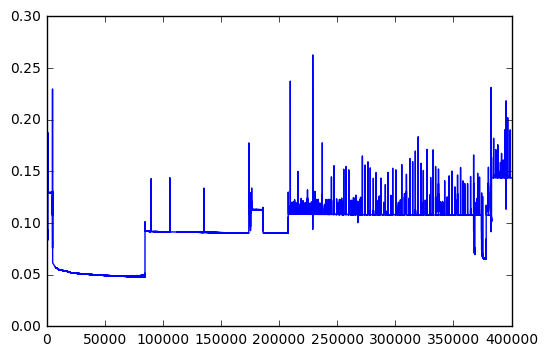

In [14]:
plt.plot(results.history['loss'])
plt.show()

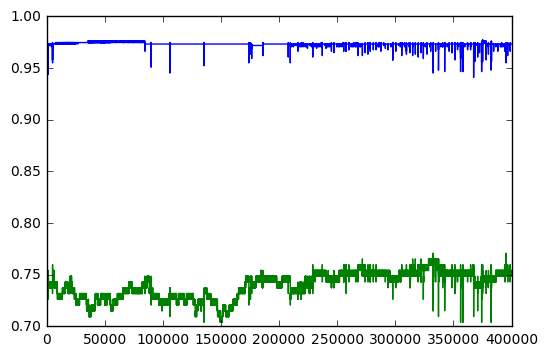

In [15]:
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.show()

In [25]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [26]:
#random seed for parameters init
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(20, np.tanh)
dnn.add_layer(10, np.tanh)
dnn.add_layer(1, DNN.sigmoid)
dnn.costfunction = DNN.binary_crossentropy
dnn.init = 'Lecun'
dnn.optimizer = 'Adam'
dnn.compile()

In [27]:
#random seed for mini batch shuffle
np.random.seed(0)

learning_rate = 0.001
epochs = 100000
batch_size = int(X_train_my.shape[1])
verbose = 1000
gradient_check = False

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='error', learning_rate=learning_rate, batch_size=batch_size, epochs=epochs, verbose=verbose, gradient_check=gradient_check)

Y_predict_my = dnn.predict(X_train_my)
Y_predict_my = Y_predict_my > 0.5
accuracy = accuracy_score(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1]))
print('Accuracy train', accuracy)

Y_predict_my = dnn.predict(X_dev_my)
Y_predict_my = Y_predict_my > 0.5
accuracy = accuracy_score(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1]))
print('Accuracy dev', accuracy)


Cost after iteration 0 ['0.687491', '0.627809', '0.653631']
Cost after iteration 1000 ['0.325965', '0.872191', '0.804469']
Cost after iteration 2000 ['0.245432', '0.901685', '0.804469']
Cost after iteration 3000 ['0.198353', '0.918539', '0.810056']
Cost after iteration 4000 ['0.166318', '0.935393', '0.810056']
Cost after iteration 5000 ['0.139335', '0.945225', '0.815642']
Cost after iteration 6000 ['0.121982', '0.953652', '0.793296']
Cost after iteration 7000 ['0.109804', '0.957865', '0.793296']
Cost after iteration 8000 ['0.101553', '0.960674', '0.798883']
Cost after iteration 9000 ['0.096563', '0.960674', '0.793296']
Cost after iteration 10000 ['0.092647', '0.962079', '0.776536']
Cost after iteration 11000 ['0.088589', '0.962079', '0.793296']
Cost after iteration 12000 ['0.086154', '0.962079', '0.787709']
Cost after iteration 13000 ['0.084364', '0.962079', '0.776536']
Cost after iteration 14000 ['0.082938', '0.963483', '0.798883']
Cost after iteration 15000 ['0.081795', '0.963483', '

In [ ]:
20/20/20/1,  lr=0.05/epochs=100000/batch_size=all/beta=0.9
Accuracy train 0.964887640449
Accuracy dev 0.765363128492

20/10/1 lr=0.0001/epochs=100000/batch_size=all/adam
Accuracy train 0.973314606742
Accuracy dev 0.737430167598

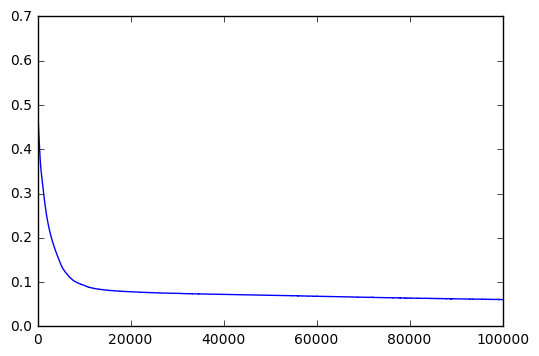

In [28]:
plt.plot(results['loss'])
plt.show()

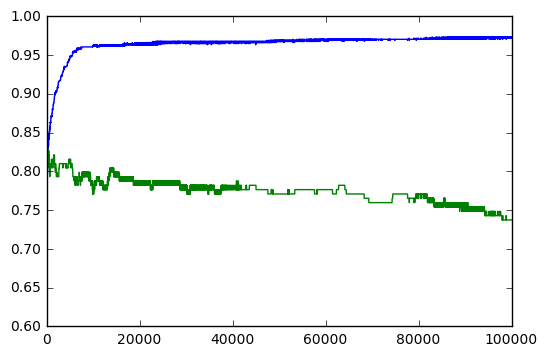

In [29]:
plt.plot(results['eval0'])
plt.plot(results['eval1'])
plt.show()